In [1]:
# import os
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer
from collections import Counter
# from num2words import num2words
# from nltk.util import bigrams
# from nltk.probability import FreqDist
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import re
# import nltk
import txtFuncts as tfs
# from wordcloud import WordCloud

import gensim # Gensim for Topic Modeling"
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
# from wordcloud import STOPWORDS, ImageColorGenerator

## Reading and Cleaning

In [2]:
corpus=tfs.readCorpus('Articles')

[====================>] 100%


In [3]:
cleanCorpus=[]
for doc in corpus:
    openInds=[]
    closeInds=[]

    # Find indices of the regular expressions
    opens=re.finditer("\nDocument.+[a-z0-9]",doc)
    closes=re.finditer("[aA]ll [rR]ights [rR]eserved",doc)
    cleanDoc=''
    for i in opens:
        openInds.append(i.span())
    for i in closes:
        closeInds.append(i.span())

    # Use the expressions to extract data and exclude metadata
    i,j=0,0
    while i<len(closeInds):
        start=closeInds[i][1]+1
        
        while openInds[j][0]<start:
            j+=1
        end=openInds[j][0]-1
        cleanDoc+=doc[start:end]+' '
        i+=1
        j+=1

    cleanDoc=re.sub(r"\(PHOTOGRAPHS BY [A-Z\W? ?]*\)",' ',cleanDoc)

    cleanCorpus.append(cleanDoc)

for i in range(len(cleanCorpus)):
    cleanCorpus[i]=cleanCorpus[i].replace('\n',' ')

In [4]:
data,tokens=tfs.preprocessText(cleanCorpus,stem=True)
topk=tfs.getkMostUsed(data,30)

data2,tokens2=tfs.preprocessText(cleanCorpus,stem=True,removeStop=True)
topk2=tfs.getkMostUsed(data2,30)

data3,tokens3=tfs.preprocessText(cleanCorpus,stem=False,removeStop=True)
topk3=tfs.getkMostUsed(data3,30)

[====================>] 100%
[====================>] 100%
[====================>] 100%


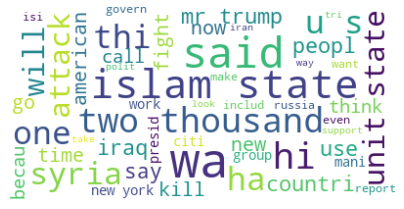

In [5]:
wordcloud=tfs.genWordCloud(data,50)
plt.figure(figsize=(7,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

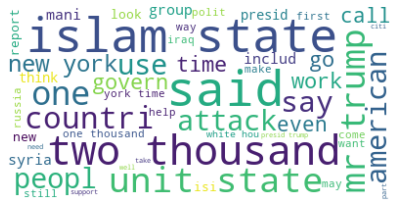

In [6]:
wordcloud=tfs.genWordCloud(data2,50)
plt.figure(figsize=(7,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

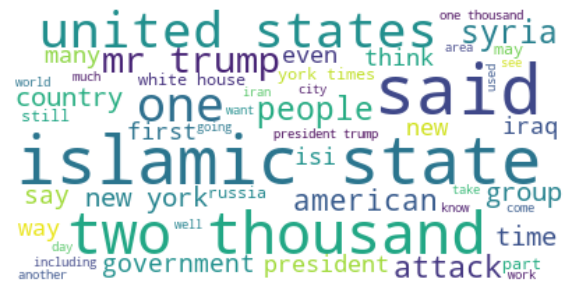

In [7]:
wordcloud=tfs.genWordCloud(data3,50)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

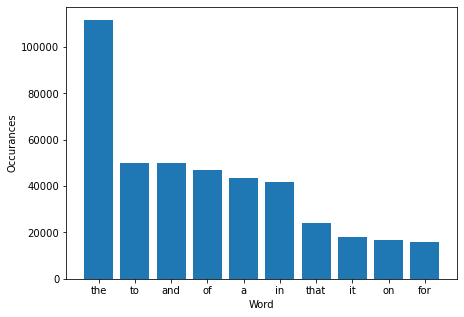

In [8]:
tfs.plotTopk(topk,10)

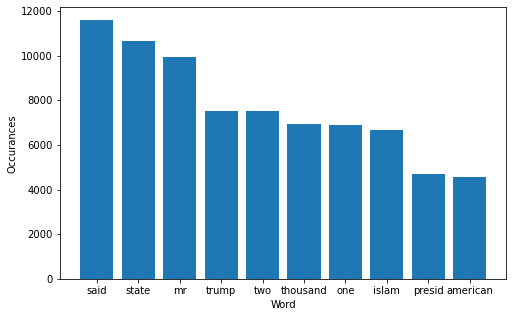

In [9]:
tfs.plotTopk(topk2,10,fwidth=8)

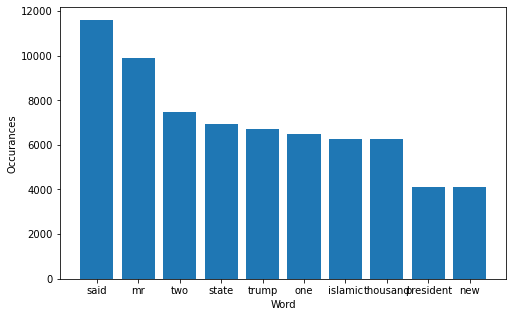

In [10]:
tfs.plotTopk(topk3,10,fwidth=8)

In [11]:
bigrams=tfs.topkBigrams(tokens3,100)

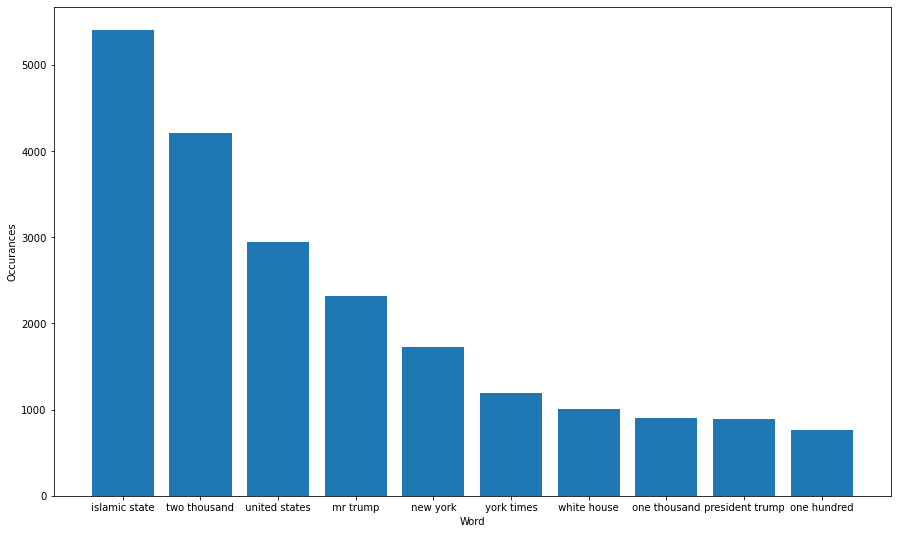

In [12]:
tfs.plotTopk(bigrams,10,fwidth=15,fheight=9)

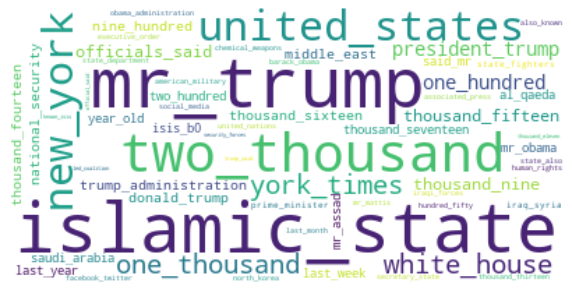

In [13]:
wordcloud=tfs.genWordCloud(bigrams,60,bigrams=True)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
data4,tokens4=tfs.preprocessText(cleanCorpus,stem=False,removeStop=True,extraWords=['mew york times','thousand','said'])
topk4=tfs.getkMostUsed(data4,30)

[====================>] 100%


In [15]:
c=0
for doc in tokens4:
    for word in doc:
        if word=='said':
            c+=1
print(c)

0


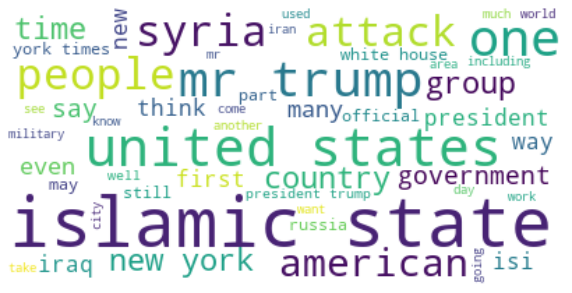

In [16]:
wordcloud=tfs.genWordCloud(data4,50)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

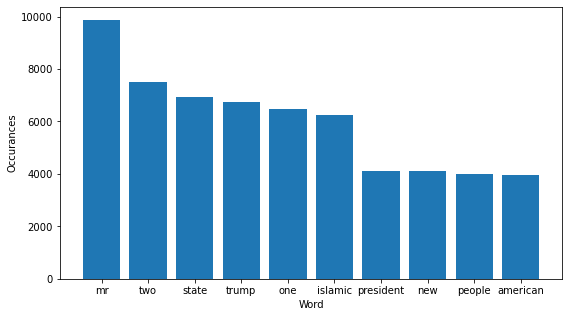

In [17]:
tfs.plotTopk(topk4,10,fwidth=9)

In [18]:
bigrams2=tfs.topkBigrams(tokens4,100)

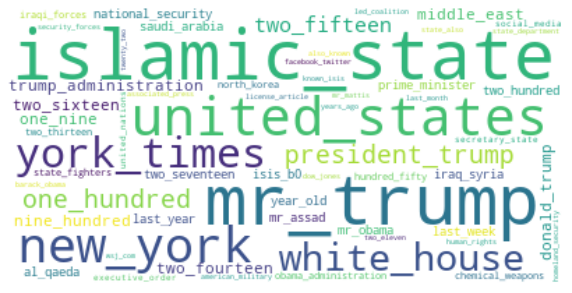

In [19]:
wordcloud=tfs.genWordCloud(bigrams2,60,bigrams=True)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
bigram=gensim.models.Phrases(tokens4, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [21]:
id2word=corpora.Dictionary(tokens4)  
texts=tokens4
corpus = [id2word.doc2bow(text) for text in texts]

In [22]:
perps=[]
coh=[]
ntops=list(range(1,21))
for n in ntops:
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=n, 
                                            random_state=100,
                                            update_every=10,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
    # Compute Perplexity
    perps.append(lda_model.log_perplexity(corpus))  
    # a measure of how good the model is. lower the better.
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens4, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coh.append(coherence_lda)
    tfs.print_progress(n,ntops[-1])

[====================>] 100%


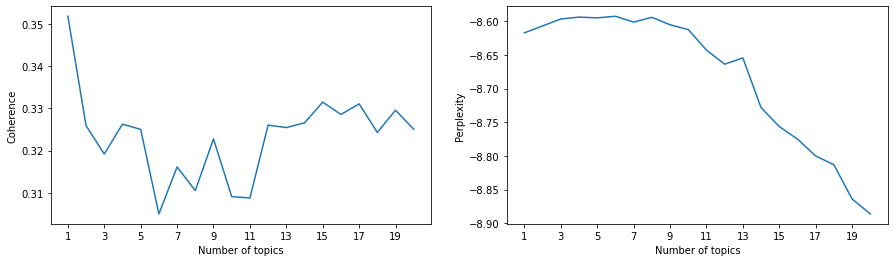

In [23]:
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(15, 4))

axs[0].plot(ntops,coh)
axs[0].set_xlabel('Number of topics')
axs[0].set_ylabel('Coherence')
axs[0].set_xticks(ntops[::2])

axs[1].plot(ntops,perps)
axs[1].set_xlabel('Number of topics')
axs[1].set_ylabel('Perplexity')
axs[1].set_xticks(ntops[::2])
plt.show()

In [24]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=11, 
                                            random_state=100,
                                            update_every=10,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [25]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"mustapha" + 0.006*"islamic" + 0.005*"fannami" + 0.005*"state" + '
  '0.004*"boko" + 0.004*"bora" + 0.004*"haram" + 0.004*"qatar" + 0.004*"emir" '
  '+ 0.003*"tora"'),
 (1,
  '0.003*"mr" + 0.003*"two" + 0.002*"islamic" + 0.002*"trump" + 0.002*"one" + '
  '0.002*"state" + 0.002*"people" + 0.002*"president" + 0.001*"syria" + '
  '0.001*"would"'),
 (2,
  '0.001*"mr" + 0.001*"trump" + 0.001*"state" + 0.001*"islamic" + 0.001*"two" '
  '+ 0.001*"one" + 0.000*"united" + 0.000*"president" + 0.000*"people" + '
  '0.000*"american"'),
 (3,
  '0.002*"mr" + 0.001*"state" + 0.001*"one" + 0.001*"two" + 0.001*"states" + '
  '0.001*"islamic" + 0.001*"president" + 0.001*"trump" + 0.001*"new" + '
  '0.001*"american"'),
 (4,
  '0.008*"state" + 0.008*"islamic" + 0.007*"mr" + 0.007*"two" + 0.006*"one" + '
  '0.004*"trump" + 0.004*"forces" + 0.003*"would" + 0.003*"syria" + '
  '0.003*"military"'),
 (5,
  '0.007*"mr" + 0.006*"two" + 0.006*"trump" + 0.005*"one" + 0.005*"state" + '
  '0.004*"polic

In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.135863  0.032038       1        1  65.000138
4      0.164229  0.017160       2        1  26.900398
6      0.168476  0.013696       3        1   6.206489
5      0.099147 -0.096193       4        1   1.606837
0     -0.045958  0.046194       5        1   0.285979
2     -0.134620 -0.008076       6        1   0.000050
9     -0.130062 -0.006447       7        1   0.000048
3     -0.107975 -0.004963       8        1   0.000037
7     -0.063460 -0.000128       9        1   0.000013
8     -0.046119  0.003369      10        1   0.000010
1     -0.039521  0.003350      11        1   0.000001, topic_info=          Term         Freq        Total Category  logprob  loglift
1459        mr  9839.000000  9839.000000  Default  30.0000  30.0000
2376       two  7450.000000  7450.000000  Default  29.0000  29.0000
2355     trump  6698.000000  6698.000000  Default  28.0000  28.0000
1560       one  6452.000000  6452.000000  Default  27.0000  27.0000
1187   islamic  6182.000000  6182.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1360      many     0.000008  2026.922883  Topic11  -7.2635  -1.0094
1415  military     0.000009  3255.715356  Topic11  -7.0720  -1.2918
1006     group     0.000008  2096.276454  Topic11  -7.2505  -1.0300
1179      iraq     0.000008  2704.736209  Topic11  -7.2146  -1.2490
2400    united     0.000008  3429.506593  Topic11  -7.2451  -1.5169

[895 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
22368      1  0.983592   08trump
22369      1  0.983144  08voters
38274      2  0.995713   10point
24896      1  0.359312   abaaoud
24896      4  0.628796   abaaoud
...      ...       ...       ...
2576       1  0.963404        —s
2576       2  0.028902        —s
13114      1  0.987187        —t
35884      5  0.876978   •ffhand
41644      2  1.001035      一带一路

[1010 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 5, 7, 6, 1, 3, 10, 4, 8, 9, 2])